# **Crawler PPO**

In [1]:
# Torch
import torch
from torch import nn
from torch import optim

# Common Util
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Environment
from env import create_env
from torchrl.envs.utils import check_env_specs

# Model
from rlkit.models import MLP
from tensordict.nn import TensorDictModule
from torchrl.modules import ProbabilisticActor, TanhNormal
from tensordict.nn.distributions import NormalParamExtractor

### Training
# Collection
from torchrl.collectors import SyncDataCollector, MultiSyncDataCollector
from torchrl.data import ReplayBuffer, LazyMemmapStorage, SliceSamplerWithoutReplacement, SamplerWithoutReplacement
# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators
# Util
from rlkit.util import Checkpointer, Logger, Stopwatch, round_up, SimpleMetricModule, ppo_loss_td_to_dict


# Config
from config import (
    ENV_PATH, 
    N_ENVS, OBSERVATION_DIM, ACTION_DIM,
    LOG_KEYS, LOG_INDEX, BEST_METRIC_KEY,
    MODEL_PATH, CKPT_PATH, LOG_PATH, RESULTS_PATH,
)

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_type = "cuda" if str(device).startswith("cuda") else "cpu"
amp_dtype   = torch.float16 if device_type == "cuda" else torch.float32
print(f"Using Device: {device}")

Using Device: cpu


## **Environment**

In [2]:
# try: env.close()
# except: pass
# env = create_env(graphics=False, time_scale=5)
# check_env_specs(env)
# td = env.rollout(1000, break_when_any_done=False)

In [3]:
# def print_specs(env):
#     print("action_spec:", env.action_spec)
#     print("reward_spec:", env.reward_spec)
#     print("done_spec:", env.done_spec)
#     print("observation_spec:", env.observation_spec)
    
# print_specs(env)

In [4]:
# env.close()
# act_data = pd.DataFrame(td["action"].reshape(-1))
# obs_data = pd.DataFrame(td["observation"].reshape(-1))
# obs_data = obs_data.clip(float(obs_data.quantile(0.01).iloc[0]), float(obs_data.quantile(0.99).iloc[0]))
# rew_data = pd.DataFrame(td["next", "reward"].reshape(-1))

# plt.violinplot(obs_data, positions=[0], showmedians=True, showextrema=True, widths=0.9)
# plt.violinplot(act_data, positions=[1], showmedians=True, showextrema=True, widths=0.9)
# plt.violinplot(rew_data, positions=[2], showmedians=True, showextrema=True, widths=0.9);

## **Model**

In [5]:
def create_policy(model_config):
    model_config = model_config.copy()
    model_config["out_features"] *= 2
    model = MLP(**model_config)

    model = nn.Sequential(
        model,
        NormalParamExtractor()
    )
    model = TensorDictModule(model, in_keys=["observation"], out_keys=["loc", "scale"])
    
    policy = ProbabilisticActor(
        module=model,  
        distribution_class=TanhNormal,

        in_keys=["loc", "scale"],
        out_keys=["action"],

        return_log_prob=True,
        log_prob_key="log_prob",
        cache_dist=True,
    )

    return policy

def create_value(model_config):
    # Remove out_features from config
    model_config = model_config.copy()
    model_config["out_features"] = 1

    model = MLP(**model_config)
    value = TensorDictModule(model, in_keys=["observation"], out_keys=["state_value"])
    return value

In [6]:
def make_loss_module(policy, value, epsilon, entropy_coef, gamma, lmbda):
    loss_module = ClipPPOLoss(
        actor_network=policy,
        critic_network=value,
        clip_epsilon=epsilon,
        loss_critic_type="smooth_l1", # Default
        entropy_coeff=entropy_coef,
        normalize_advantage=True,
    )

    loss_module.make_value_estimator(
        ValueEstimators.GAE, 
        # time_dim=-1,
        gamma=gamma, lmbda=lmbda, 
        shifted=True,
        auto_reset_env=True,
    )

    # All defaults
    loss_module.set_keys(
        # From value estimator
        advantage='advantage',
        value_target='value_target', 
        value='state_value', 
        # From policy (should match ProbabilisticActor, this is correctly set automatically key not specified)
        sample_log_prob='log_prob',
        action='action', 
        # For value estimator
        reward='reward', 
        done='done', 
        terminated='terminated',
    )

    return loss_module

## **Config**

In [7]:
# ENV Params
TIME_SCALE = 5

# PPO Params
GAMMA = 0.99
GAE_LAMBDA = 0.95
EPSILON = 0.2
ENTROPY_COEF = 1e-2

In [8]:
MODEL_CONFIG = {
    "hidden_dim": 1024,
    "n_blocks": 3,
    "in_features": OBSERVATION_DIM,
    "out_features": ACTION_DIM,
}

In [15]:
# Collection Phase Params
WORKERS = os.cpu_count() // 2
STORAGE_DEVICE = "cpu"
COLLECTOR_BUFFER_SIZE = round_up(70_000, WORKERS*N_ENVS)
GENERATION_SIZE = round_up(COLLECTOR_BUFFER_SIZE, COLLECTOR_BUFFER_SIZE)
GENERATIONS = 1000

# Advantage Phase Params
SLICE_LEN = 256 # GAE Window
n_slices = 128
ADV_MINIBATCH_SIZE = SLICE_LEN * n_slices
print(f"max adv batch_size = {ADV_MINIBATCH_SIZE}")

# Train Phase Params
EPOCHS = 5
MINIBATCH_SIZE = 1024
LR = 5e-5
MAX_GRAD_NORM = 0.5
CLIP_FRACTION_TARGET = 0.3

P_COEF = 0.25
V_COEF = 1

max adv batch_size = 32768


In [16]:
# Intervals
LOG_INTERVAL = 1
CHECKPOINT_INTERVAL = 1

# Run Info
NAME = 'run2'
CONTINUE = True

In [17]:
def summary():
    s = [
        ("workers", WORKERS), ("parallel envs", WORKERS*N_ENVS),
        ("generation_size", GENERATION_SIZE), ("generations", GENERATIONS), ("timesteps", GENERATIONS*GENERATION_SIZE),
        ("device", device),
    ]
    for key, value in s:
        print(f"{key} = {value} ")
summary()

workers = 7 
parallel envs = 70 
generation_size = 70000 
generations = 1000 
timesteps = 70000000 
device = cpu 


## **Train**

In [18]:
def train(create_env, policy, value, generations=GENERATIONS):
    # Loss + Optimizer
    loss_module = make_loss_module(policy, value, epsilon=EPSILON, entropy_coef=ENTROPY_COEF, gamma=GAMMA, lmbda=GAE_LAMBDA)
    optimizer = optim.Adam(loss_module.parameters(), lr=LR)
    scaler = torch.amp.GradScaler(enabled=(amp_dtype == torch.float16))

    # Logger + Checkpointer
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=NAME)
    checkpointer = Checkpointer(ckpt_path=CKPT_PATH, name=NAME)

    # Continue/Reset
    start_generation = 0
    if not CONTINUE:
        logger.reset()
        checkpointer.reset()
    else:
        checkpoint = checkpointer.load_progress()
        if checkpoint:
            start_generation = int(checkpoint["generation"])
            policy.load_state_dict(checkpoint["policy_state_dict"])
            value.load_state_dict(checkpoint["value_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            if "scaler_state_dict" in checkpoint:
                scaler.load_state_dict(checkpoint["scaler_state_dict"])
            print("CHECKPOINT FOUND, STARTING FROM GENERATION:", start_generation)
        else:
            print("CHECKPOINT NOT FOUND, STARTING FROM SCRATCH")

    # Watches + Metrics
    short_watch = Stopwatch()
    long_watch = Stopwatch()
    metric_module = SimpleMetricModule(mode="approx")

    # Replay Buffers
    collect_replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(GENERATION_SIZE, device=STORAGE_DEVICE, ndim=2 + int(WORKERS > 1)),
        sampler=SliceSamplerWithoutReplacement(
            slice_len = SLICE_LEN,
            shuffle=False, strict_length=False, 
            end_key=("next", "done")
        ),
        batch_size=ADV_MINIBATCH_SIZE,
    )
    train_replay_buffer = ReplayBuffer(storage=LazyMemmapStorage(GENERATION_SIZE, device=STORAGE_DEVICE), sampler=SamplerWithoutReplacement(), batch_size=MINIBATCH_SIZE)

    # Collectors
    if WORKERS > 1:
        collector = MultiSyncDataCollector([create_env]*WORKERS, policy, 
            frames_per_batch=COLLECTOR_BUFFER_SIZE, 
            total_frames=GENERATION_SIZE*(generations - start_generation), 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE, 
            reset_at_each_iter=False,
            update_at_each_batch=False, # Manually update
        )
    else:
        collector = SyncDataCollector(
            create_env, policy, 
            frames_per_batch=COLLECTOR_BUFFER_SIZE, 
            total_frames=GENERATION_SIZE*(generations - start_generation), 
            env_device="cpu", device=device, storing_device=STORAGE_DEVICE,
            reset_at_each_iter=False,
        )


    collector_iters_per_gen = int(np.ceil(GENERATION_SIZE / COLLECTOR_BUFFER_SIZE))
    long_watch.start()

    ### TRAINING LOOP
    for i in range(start_generation, generations):
        # 1. COLLECT TRAJECTORY DATASET
        policy.eval(); value.eval()
        if WORKERS > 1: 
            collector.update_policy_weights_()

        short_watch.start(); 
        collect_replay_buffer.empty()
        # Buffer in memory then move to memory mapped storage in loop
        for j in range(collector_iters_per_gen):
            data = collector.next()
            collect_replay_buffer.extend(data)
        
        collection_time = short_watch.end()
        logger.add({"collection_time": collection_time})

        # 2. Compute Advantages, Value Target, and Metrics (Iterate Along Trajectories)
        train_replay_buffer.empty()
        for j, batch in enumerate(collect_replay_buffer):
            batch = batch.to(device)
        
            with torch.no_grad():
                loss_module.value_estimator(batch)
                metrics = metric_module(batch)
            
            logger.acc(metrics, mode='avg')
            train_replay_buffer.extend(batch.reshape(-1).cpu())
        collect_replay_buffer.empty() # A bit inefficient to only delete here

        # 3. Minibatch Gradient Descent Loop (Iterate along random timesteps)
        short_watch.start()
        policy.train(); value.train()

        for epoch in range(EPOCHS):
            for j, batch in enumerate(train_replay_buffer):
                # 2.1 Optimization Step
                batch = batch.to(device)
                with torch.autocast(device_type=device_type, dtype=amp_dtype, enabled=(amp_dtype==torch.float16)):
                    loss_data = loss_module(batch)
                    loss = P_COEF * loss_data["loss_objective"] + V_COEF * loss_data["loss_critic"] + loss_data["loss_entropy"]
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()

                scaler.unscale_(optimizer)
                nn.utils.clip_grad_norm_(loss_module.parameters(), max_norm=MAX_GRAD_NORM)

                scaler.step(optimizer)
                scaler.update()

                # 2.2 Accumulate Metric
                weight = float(batch.batch_size[0])
                logger.acc(ppo_loss_td_to_dict(loss_data, weight), mode='ema')
            print(epoch + 1)
            if logger.last()["clip_fraction"] > CLIP_FRACTION_TARGET: break

        train_replay_buffer.empty()
        policy.eval(); value.eval()
        train_time = short_watch.end()
        logger.add({"train_time": train_time})

        # 4. Log results
        logger.add({"generation": 1})
        logger.add({"timestep": GENERATION_SIZE})
        if (i % LOG_INTERVAL) == 0:
            logger.add({"time": long_watch.end()})
            long_watch.start()
            logger.next(print_row=True)
        
        # 5. Checkpoint model
        if (i % CHECKPOINT_INTERVAL) == 0:
            gen = i + 1
            metric = metrics[BEST_METRIC_KEY]
            checkpointer.save_progress(metric_key=BEST_METRIC_KEY,
            state_obj={
                "generation": gen,
                "policy_state_dict": policy.state_dict(),
                "value_state_dict": value.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "scaler_state_dict": scaler.state_dict(),
                BEST_METRIC_KEY: metric,
            })

    checkpointer.copy_model('latest', MODEL_PATH, ('policy_state_dict', 'value_state_dict'))
    return logger.dataframe()

In [ ]:
policy = create_policy(MODEL_CONFIG).to(device)
value = create_value(MODEL_CONFIG).to(device)

env_fn = lambda: create_env(time_scale=TIME_SCALE)

train(env_fn, policy, value, generations=GENERATIONS)

CHECKPOINT FOUND, STARTING FROM GENERATION: 3
[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-siz

In [14]:
def plot(name):
    # Get dataframe
    logger = Logger(keys = LOG_KEYS, log_path=LOG_PATH, name=name)
    df = logger.dataframe()
    df = df.set_index(LOG_INDEX)

    # Plot it
    rows = (len(df.columns) + 3) // 4
    df.plot(subplots=True, layout=(rows,4), figsize=(15, int(rows* 7/3)))
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_PATH, f"{name}.png"))

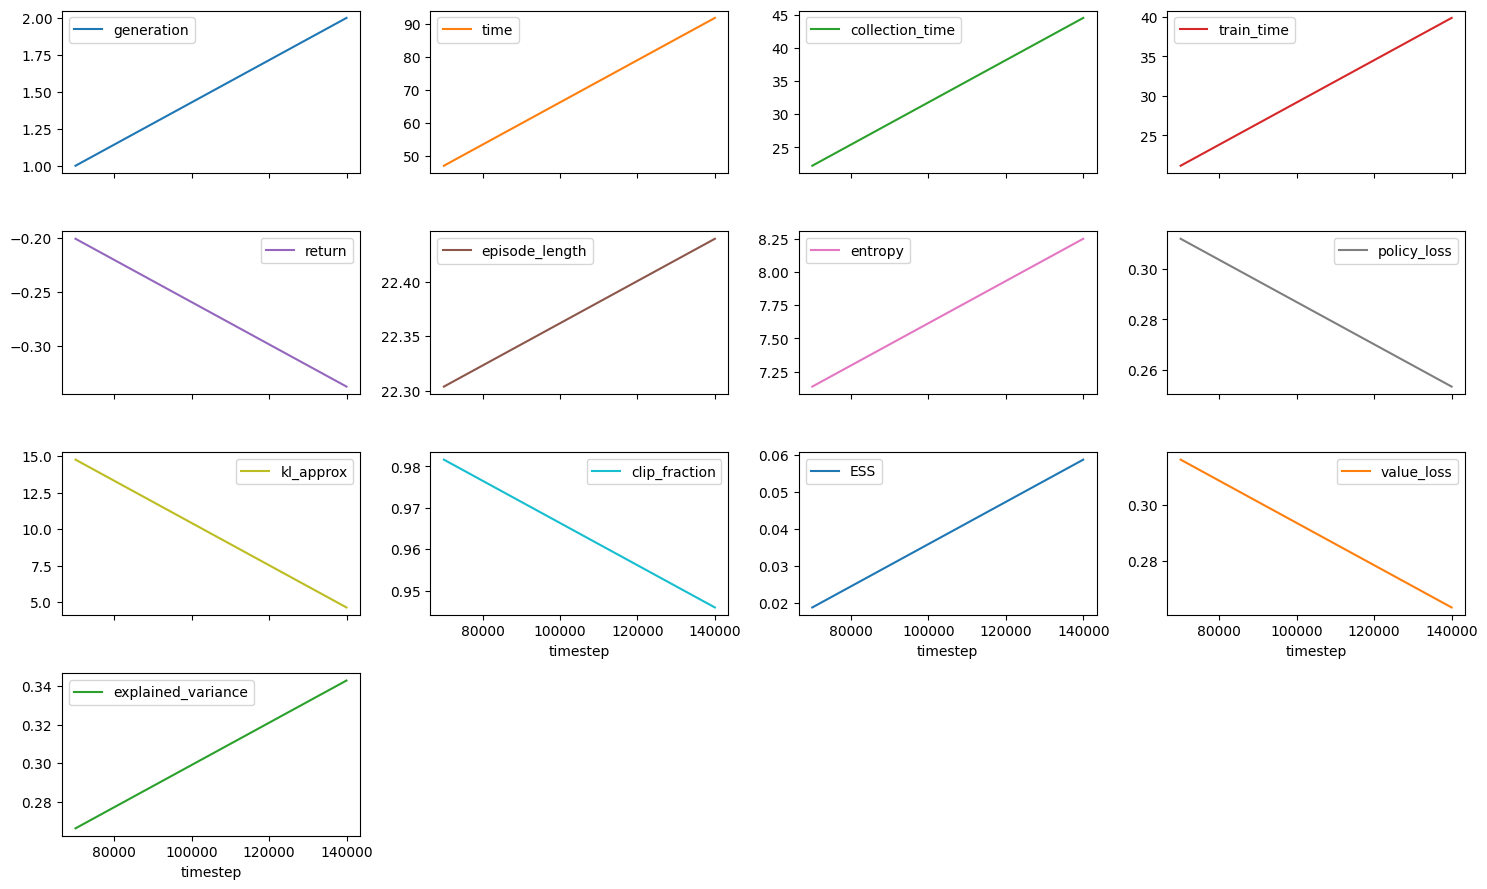

In [ ]:
plot(NAME)

In [120]:
# checkpointer = Checkpointer(ckpt_path=CKPT_PATH, name=NAME)
# checkpoint = checkpointer.load_progress()

# policy = create_policy(MODEL_CONFIG).to(device)
# policy.load_state_dict(checkpoint["policy_state_dict"])
def load_policy(policy, model_path, name):
    model_params = torch.load(os.path.join(model_path, f"{name}.pt"), map_location=device, weights_only=True)
    policy.load_state_dict(model_params["policy_state_dict"])
OLD_MODEL_CONFIG = {
    "hidden_dim": 256,
    "n_blocks": 3,
    "in_features": OBSERVATION_DIM,
    "out_features": ACTION_DIM,
}
policy = create_policy(OLD_MODEL_CONFIG).to(device)
# load_policy(policy, MODEL_PATH, 'run5')

In [132]:
try: env.close()
except: pass

env = create_env(graphics=True, time_scale=TIME_SCALE)
data = None
with torch.no_grad():
    data = env.rollout(1000, policy=policy, break_when_any_done=False)

[UnityMemory] Configuration Parameters - Can be set up in boot.config
    "memorysetup-bucket-allocator-granularity=16"
    "memorysetup-bucket-allocator-bucket-count=8"
    "memorysetup-bucket-allocator-block-size=4194304"
    "memorysetup-bucket-allocator-block-count=1"
    "memorysetup-main-allocator-block-size=16777216"
    "memorysetup-thread-allocator-block-size=16777216"
    "memorysetup-gfx-main-allocator-block-size=16777216"
    "memorysetup-gfx-thread-allocator-block-size=16777216"
    "memorysetup-cache-allocator-block-size=4194304"
    "memorysetup-typetree-allocator-block-size=2097152"
    "memorysetup-profiler-bucket-allocator-granularity=16"
    "memorysetup-profiler-bucket-allocator-bucket-count=8"
    "memorysetup-profiler-bucket-allocator-block-size=4194304"
    "memorysetup-profiler-bucket-allocator-block-count=1"
    "memorysetup-profiler-allocator-block-size=16777216"
    "memorysetup-profiler-editor-allocator-block-size=1048576"
    "memorysetup-temp-allocator-siz

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/transforms/transforms.py:587: FutureWarning: The key 'continuous_action' is unaccounted for by the transform (expected keys ['PhysicsBodySensor:Body', 'VectorSensor_size32', 'done', 'terminated', 'truncated', 'group_reward', 'reward']). Every new entry in the tensordict resulting from a call to a transform must be registered in the specs for torchrl rollouts to be consistently built. Make sure transform_output_spec/transform_observation_spec/... is coded correctly. This warning will trigger a KeyError in v0.9, make sure to adapt your code accordingly.
  warnings.warn(


Thread 0x16d57b000 may have been prematurely finalized
Setting up 7 worker threads for Enlighten.
Thread 0x16c067000 may have been prematurely finalized
Memory Statistics:
[ALLOC_TEMP_TLS] TLS Allocator
  StackAllocators : 
    [ALLOC_TEMP_MAIN]
      Peak usage frame count: [1.0 KB-2.0 KB]: 54 frames, [2.0 MB-4.0 MB]: 1 frames
      Initial Block Size 4.0 MB
      Current Block Size 4.0 MB
      Peak Allocated Bytes 2.1 MB
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worker 4]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Loading.PreloadManager]
      Initial Block Size 256.0 KB
      Current Block Size 256.0 KB
      Peak Allocated Bytes 79.4 KB
      Overflow Count 5
    [ALLOC_TEMP_Background Job.worker 3]
      Initial Block Size 32.0 KB
      Current Block Size 32.0 KB
      Peak Allocated Bytes 0 B
      Overflow Count 0
    [ALLOC_TEMP_Background Job.worker 11]
      Initial Block

/opt/homebrew/anaconda3/envs/mlagents3/lib/python3.10/site-packages/torchrl/envs/libs/unity_mlagents.py:373: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  source[group_name][agent_name]["truncated"] = torch.tensor(


In [133]:
try: env.close()
except: pass
SimpleMetricModule(mode="approx")(data)

{'return': -0.8711285591125488,
 'episode_length': 15.384614944458008,
 'entropy': 11.055976867675781}

In [134]:
torch.nonzero(data["next", "terminated"])

tensor([[  0,   6,   0],
        [  0,  15,   0],
        [  0,  25,   0],
        ...,
        [  9, 975,   0],
        [  9, 987,   0],
        [  9, 999,   0]])

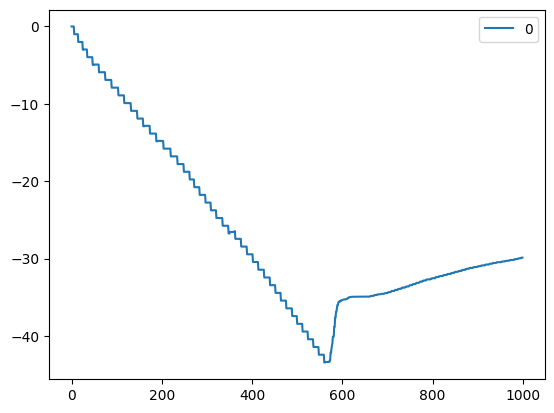

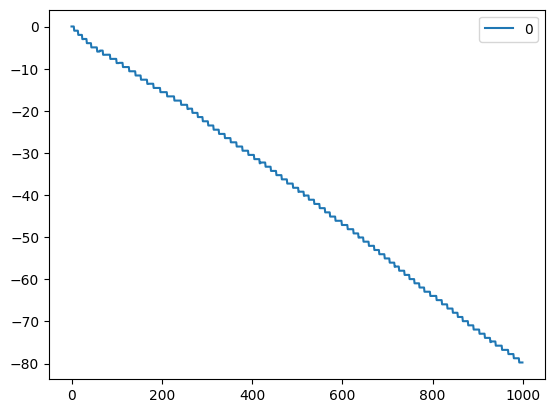

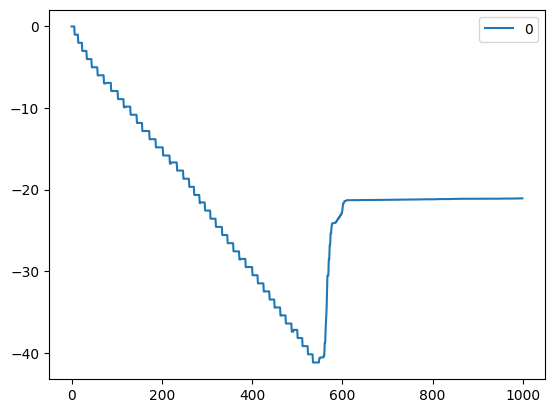

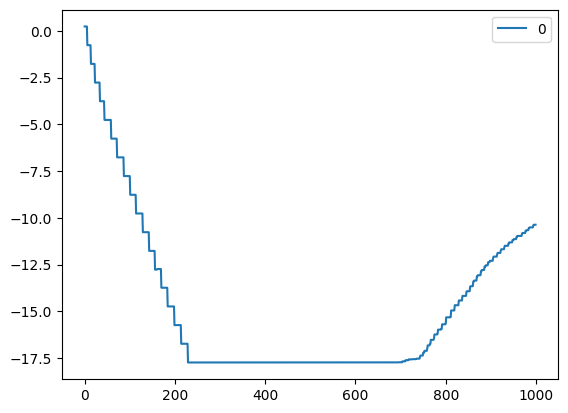

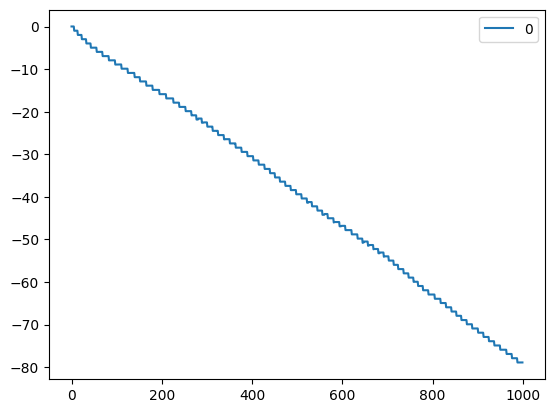

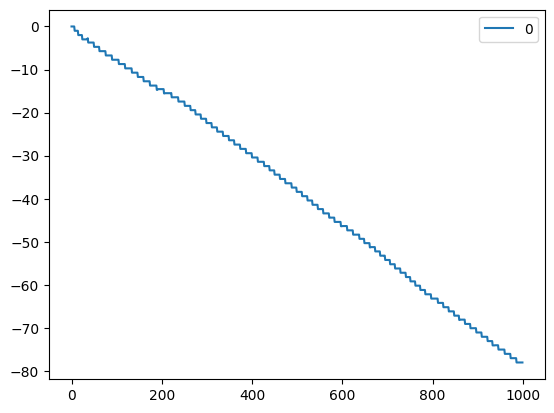

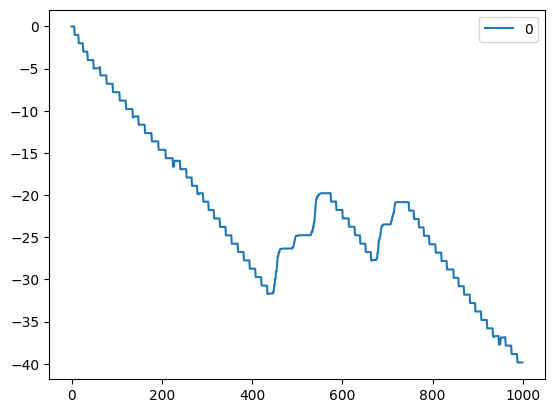

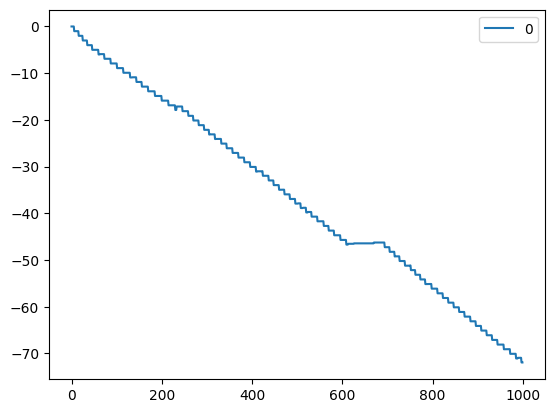

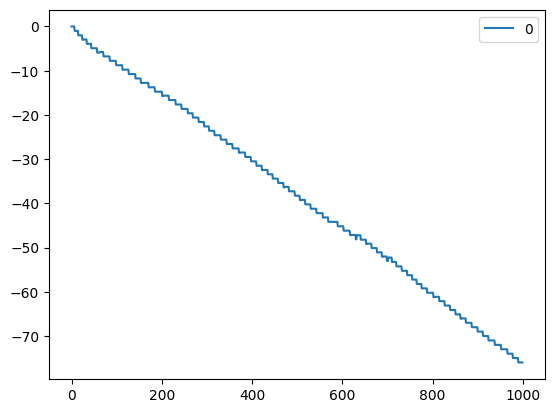

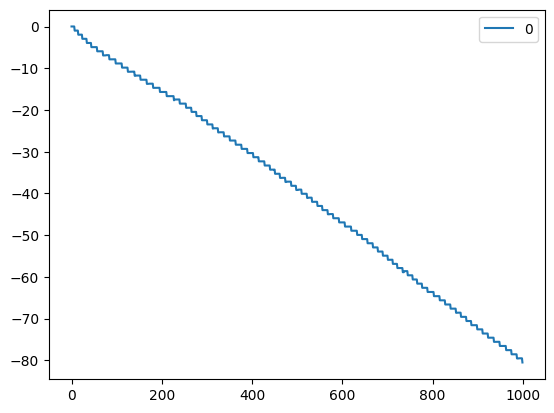

In [ ]:
for i in range(10):
    reward_data = data["next", "reward"][i].squeeze().cumsum(dim=0)
    pd.DataFrame(reward_data).plot()

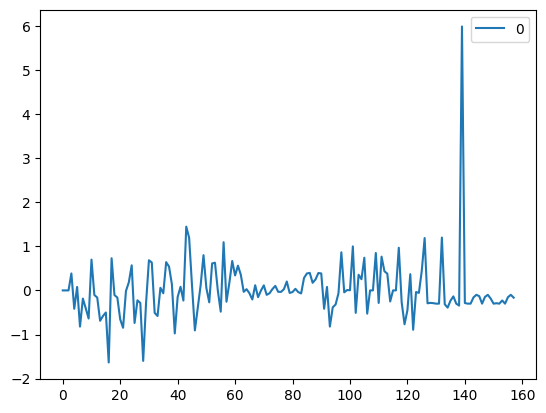

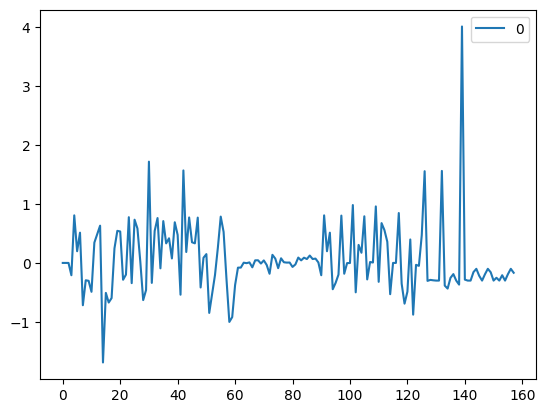

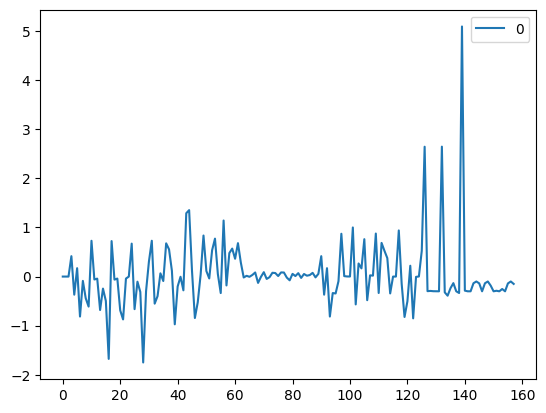

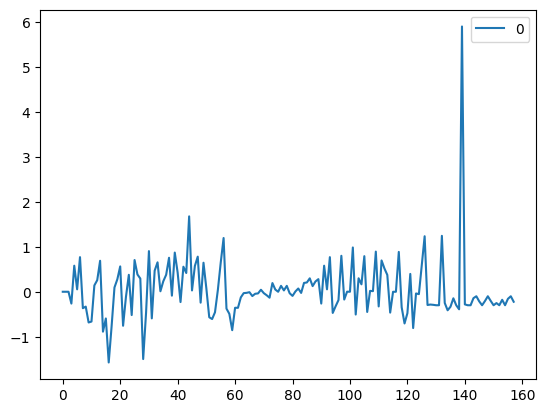

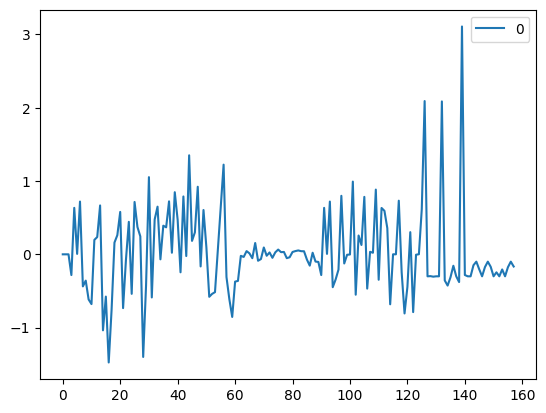

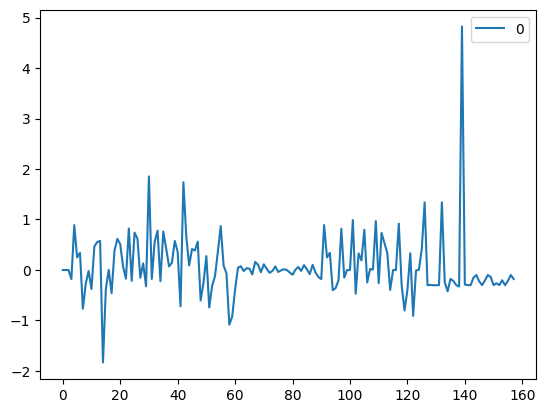

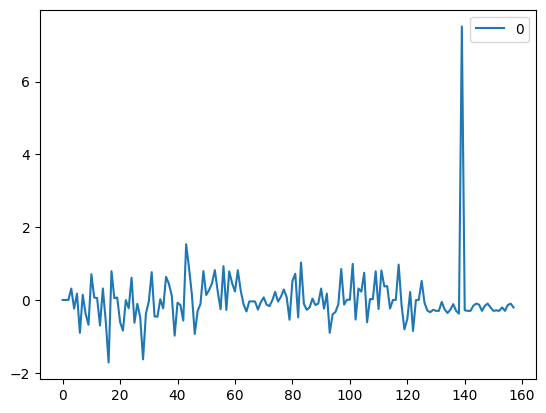

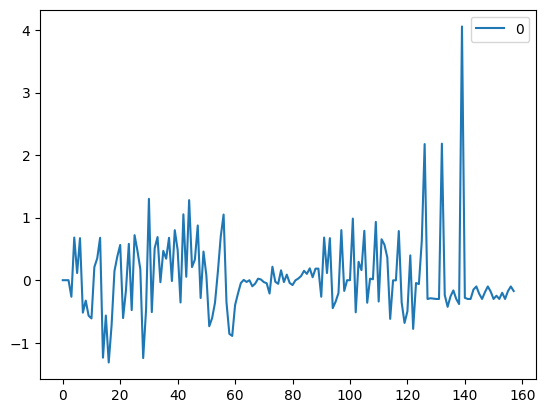

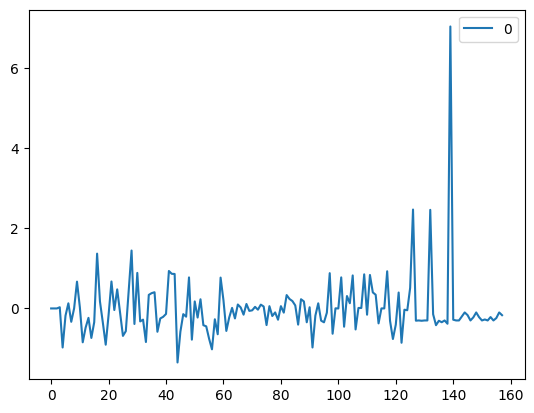

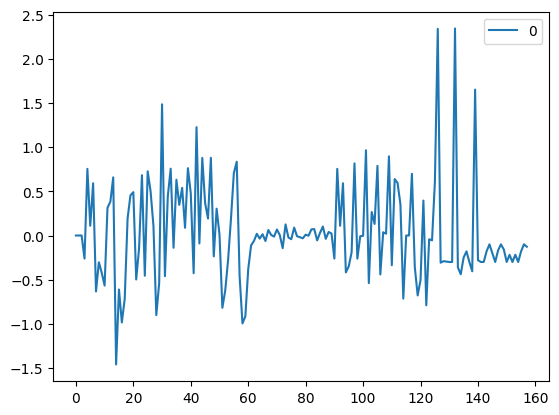

In [ ]:
for i in range(10):
    action_data = data["observation"][i].squeeze()[-200]
    pd.DataFrame(action_data).plot()